# DR oxygen analysis

Weronika Biela-Nowaczyk

2024

In [1]:
import numpy as np
import re
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import os
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.optimize import minimize_scalar
%matplotlib inline

In [2]:
# Constants
RCATH=0.002            # Cathode radius [m]
RTUBE=0.05             # Tube radius [m]
EXP_FACTOR=33                # Adiabatic beam EXP_FACTORansion factor
MASS_ION= 14899168637  #14896453700  #14896453700   # ion mass [eV/c²] -> oxygen BUT! find better
u = 931494102.42       #eV/c^2
MASS_ION_AMU=15.99491461956   # ion mass [amu] -> neon ??????? 20?
ETA=0.014807#   0.020303     #   # COOL_LENGTH/CIRC
COOL_LENGTH=0.9        # Cooler interaction zone length [m]; assume error of 1 cm
CIRC=54.029            # Ring orbit [m]; error ca. 12.5 cm assuming the orbit might be 2 cm further out or in
F_REV =810033          # revolution frequency [Hz] from Beamcalc

#determine/estimate appropriate error values
# RCATH_ERROR=0.0002   #10%
# RTUBE_ERROR=0.0001   #1/10 of a mm machining tolerance
# ECOOL_ERROR=1.0      #based on RR symmetrization
# ECUR_ERROR=0.0002    #10%
# EXP_FACTOR_ERROR=0.1        #no idea
# ETA_ERROR=0.00023    #see assumptions for COOL_LENGTH and CIRC above
# F_REV_ERROR=2500

# Fundamental constants. 
C_LIGHT=299792458              # Speed of light [m/s]
ELEM_CHARGE=1.60217653e-19     # Elementary charge [C]
AMU=931.494102e6               # eV
AMU_KG=1.66053886e-27          # Atomic mass [kg]
MASS_E=510998.950              # Electron mass [eV x c²], CODATA2018
MASS_E_KG=9.1093826e-31        # Electron mass [kg]
# BOLTZMANN=8.617343e-5          # [eV/K]
# BOLTZMANN_J=BOLTZMANN*ELEM_CHARGE              # [J/K]
# ALPHA=7.297352568e-3            # ~1/137
# G_E=2.0231930436                # g-Factor electron (CODATA)
EPSILON_0=8.854187817e-12       # C/Vm
# MU_0=4.*np.pi*1e-7                 # permeability of free space, (N*A^2) SI units.
RYDBERG_CONST=13.6056923        # eV



# data paths

exp_data_path ='./data/exp/'
theory_data_path ='./data/theory/'

# CryringData Class 

In [3]:

class CryringData:
    def __init__(self, filename):
        self.name = filename[18:20]    # Extract the substring containing the desired name
        self.prepare_data(filename)

    
    def prepare_data(self, filename):
        myvars = {}
        with open(filename) as myfile:
            for cnt in range(88):
                line = next(myfile)
                if ':' in line:
                    name, var = line.partition(':')[::2]
                    name = name.strip().strip('#')
                    var = var.strip()
                    myvars[name.strip()] = var                
            header_line = next(myfile)
        
        #Values useful for me from header
        try: #for FC and RF 
            self.e_curr = float(myvars['electron current (mA)'])*0.001
        except KeyError:
            if self.name == "04":
                self.e_curr = 21*0.001
            else:
                self.e_curr = 19.47*0.001
        try:
            self.main_pow_supply = float(myvars['cath meas voltage (V)'])
        
        except KeyError:
            if self.name == "01":
                self.main_pow_supply = 5580.5 
            elif self.name == "03" or self.name == "04":
                self.main_pow_supply = 3500
            else:
                self.main_pow_supply = 3000
        
        self.cooling_energy = float(myvars['cooling energy (eV)']) #this is not the best chice- it is a set value- better from shotky
        try: 
            self.ion_energy = float(myvars['ion energy (MeV/u)'])
        except KeyError:
            if self.name == "01" or self.name == "03" or self.name == "04":
                self.ion_energy = 10.1417
            else:
                self.ion_energy = 10.144
        #self.header_keys = myvars.keys()
        #self.header_values = myvars.values()
        
        #Labels give the labels for each array in self.data
        header_line = header_line.strip('#')
        header_line = re.split(r'\[\d+\]', header_line)
        self.labels = header_line
        #Data - without last two columns (there is str "-")
        if self.name == "06":
            start_row = 134 #89 row of "preambule" +no. of rows to delete
            self.data = np.genfromtxt(filename, delimiter=',', usecols=range(0, 41, 1), dtype=float, skip_header=start_row)
        elif self.name == "13":
            start_row = 218  
            self.data = np.genfromtxt(filename, delimiter=',', usecols=range(0, 41, 1), dtype=float, skip_header=start_row)
        
        else:
            self.data = np.genfromtxt(filename, delimiter=',',usecols=range(0, 41, 1),dtype=float)
         
    

    
    ############################################################################
    #
    #    Electron-ion energy
    #
    ############################################################################
    
    def ElabtoEsc(self, Elab):
        """
        Performs space-charge correction on lab energy values
        Esther
        """
        SC = 0
        Eold, Enew, ne, acc1, acc, eps, factor = 0, 0, 0, 0, 1.0, 0.0000001, 0
        i, maxiter, sign = 0, 100, 0
        factor = ELEM_CHARGE*RCATH*RCATH*EXP_FACTOR/(4*EPSILON_0) * (1 + 2*np.log(RTUBE/(RCATH*np.sqrt(EXP_FACTOR))))
        while np.all(acc > eps) and i < maxiter:
            Eold = Enew
            Enew = Elab - SC
            ne = self.Edensity(Elab)
            SC = ne * factor
            acc1 = Eold / Enew - 1
            sign = np.where(acc1 > 0, 1, -1)
            acc = sign * acc1
            i += 1
        return Enew
    
    def ElabtoEsc_err(self, Elab, Elab_err):
        """
        Performs error calculation for the space-charge correction
        based on Esther code
        
        Problem: here we have the Elab_err as a input from cooler calibration, 
        for me this error for Elab will be HUGE! I use a smoothing function of Arnold output
        """
        #uncertain parameters: RTUBE, RCATH, EXP_FACTOR, ECUR, Elab
        dd = RTUBE / RCATH / math.sqrt(EXP_FACTOR)
        dd_err = 1/RCATH/np.sqrt(EXP_FACTOR)*RTUBE_ERROR + RTUBE/(RCATH*RCATH)/math.sqrt(EXP_FACTOR)*RCATH_ERROR + 0.5*RTUBE/RCATH/math.pow(EXP_FACTOR, 2/3)*EXP_FACTOR_ERROR
        factor = 0.25 * (1.0 + 2.0 * math.log(dd))/(np.pi * EPSILON_0 * C_LIGHT) * ECUR / MASS_E
        factor_err = 0.25/(np.pi*EPSILON_0*C_LIGHT*MASS_E) * (ECUR * dd_err + math.log(dd) * ECUR_ERROR)
        Uk = Elab / MASS_E
        Uk_err = Elab_err/MASS_E

        enew = ElabtoEsc(Elab)  # define ElabtoEsc function
        enew_err = Uk_err + factor_err*(enew+1)/math.sqrt(enew*(enew+1))

        Esc_err = enew_err * MASS_E
        return Esc_err

    def EsctoEcm(self, Esc):
        """
        Performs transformation of (space-charge corrected) lab energy to centre-of-mass energy
        Esther
        """
        Correction_RAMP01 = 14.1382#08157278314 #this correction was obtained from analysis of Ramp01 and Ramp13
        Correction_RR = 0.846 #value was obtained based on the RR peak position analysis
        Ecool = self.ElabtoEsc(self.cooling_energy+Correction_RAMP01)+Correction_RR
        Ei = Ecool * MASS_ION / MASS_E
        sign = np.ones_like(Esc)
        sign[Esc > Ecool] = 1
        sign[Esc <= Ecool] = -1

        aa = MASS_ION + MASS_E
        sqrti = np.sqrt(Ei * (Ei + 2 * MASS_ION))
        sqrte = np.sqrt(Esc * (Esc + 2 * MASS_E))
        bb = Ei * Esc + Ei * MASS_E + Esc * MASS_ION - sqrti * sqrte

        Ec = sign * (np.sqrt(aa*aa + 2 * bb) - aa)
        return Ec
    
    
    
#     def EsctoEcm_err(self, Esc, Esc_err):
#         """
#         Performs error calcuation for the lab-to-cm transformation
#         """
#         Ecool = self.cooling_energy
#         Ei = Ecool * MASS_ION / MASS_E
#         Ei_err = Ecool_err * MASS_ION / MASS_E #assume no error for MASS_ION and MASS_E
#         aa = MASS_ION + MASS_E #no error
#         sqrti = np.sqrt(Ei * (Ei + 2 * MASS_ION))
#         sqrti_err = Ei_err / np.sqrt(Ei * (Ei + 2 * MASS_ION)) * (Ei + MASS_ION)
#         sqrte = np.sqrt(Esc * (Esc + 2 * MASS_E))
#         sqrte_err = Esc_err / np.sqrt(Esc * (Esc + 2 * MASS_E)) * (Esc + MASS_E)
#         bb = Ei * Esc + Ei * MASS_E + Esc * MASS_ION - sqrti * sqrte
#         bb_err = (Ei_err * (Esc + MASS_E) + Esc_err * (Ei + MASS_ION) +
#                   sqrti * sqrte_err + sqrte * sqrti_err)
#         Ec_err = bb_err / np.sqrt(aa * aa + 2 * bb)
#         return Ec_err

    def smoothen_G35(self, cutoff=0):
        """
        To analyse the differences between different ramps in correction of energy (Uset(Arnold))
        """
        if self.name == "01":
            value = 25000
        elif self.name == "03": 
            value = 160
            translation = -0.584756
        elif self.name == "04": 
            value = 478
            translation = 0.140271
        elif self.name == "05": 
            value = 180
            translation = 0.205312
        elif self.name == "06": 
            value = 750
            translation = -0.315073
        elif self.name == "07": 
            value = 430        
            translation = -1
        elif self.name == "08": 
            value = 350
            translation = -0.326453
        elif self.name == "09": 
            value = 8500
            translation = -0.183992
        elif self.name == "10": 
            print("SPARK? wird Arnold behaviour")
        elif self.name == "11": 
            value = 1080
            translation = -0.810618
        elif self.name == "12": 
            translation = -0.315073
            if self.data[0,3]<-500:
                value = 67
            else:
                value = 90         
        elif self.name == "13": 
            value = 235 
            translation = 0
        else: value =200
       
        if self.main_pow_supply == 5580.5:
            slope = 0.99957
            intercept = 0.74
        elif self.main_pow_supply == 3500:
            slope = 0.99974
            intercept = -0.048
        else:# self.main_pow_supply == 3000:
            slope = 0.99977
            intercept = -0.05
        x = self.data[cutoff:,0]
        y = self.data[cutoff:,13] #Arnold
        spl = UnivariateSpline(x, y, s=value)
        y_fit = spl(x)*slope+intercept #G35
        correction = np.mean(y_fit-y)
        return y_fit-correction#+translation
    
    
    def error_smoothen_G35(self, cutoff=0):
        x = self.data[cutoff:,0]
        y = self.data[cutoff:,13] #Arnold
        return np.abs(self.smoothen_G35()-y)
    
    def EsctoEcm2(self, Esc, step):
        """
        Performs transformation of (space-charge corrected) lab energy to centre-of-mass energy
        Esther
        """
        Correction_RAMP01 = 14.1382#08157278314 #this correction was obtained from analysis of Ramp01 and Ramp13
        Correction_RR = 0.846 #value was obtained based on the RR peak position analysis
        Ecool = self.ElabtoEsc(self.cooling_energy+Correction_RAMP01+step)+Correction_RR
        Ei = Ecool * MASS_ION / MASS_E
        sign = np.ones_like(Esc)
        sign[Esc > Ecool] = 1
        sign[Esc <= Ecool] = -1

        aa = MASS_ION + MASS_E
        sqrti = np.sqrt(Ei * (Ei + 2 * MASS_ION))
        sqrte = np.sqrt(Esc * (Esc + 2 * MASS_E))
        bb = Ei * Esc + Ei * MASS_E + Esc * MASS_ION - sqrti * sqrte

        Ec = sign * (np.sqrt(aa*aa + 2 * bb) - aa)
        return Ec
    
        
################################################################################
        
    def calibration_NEW2(self, step=0, cutoff=0):
        """
        Performs calibration for energy
        """
        return np.abs(self.EsctoEcm2(self.ElabtoEsc(self.smoothen_G35()), step))



    def calibration_LAB(self):
        """
        Performs calibration for energy, for oxygen data collection we had a long jump of main power supply 
        and the arnold values are deformated at begining, moreover they are scaterred (needs to be smoothen-> value)
        """
        if self.main_pow_supply == 5580.5:
            slope = 0.99957
            intercept = 0.74
        elif self.main_pow_supply == 3500:
            slope = 0.99974
            intercept = -0.048
        else:# self.main_pow_supply == 3000:
            slope = 0.99977
            intercept = -0.05
        y_fit = self.smoothen_G35()*slope+intercept
        return np.abs(self.ElabtoEsc(y_fit))
    
    #################################################################################
    #
    #    Background, ion density, alpha itp
    #
    #################################################################################
    
    def background_subtraction(self):
        y = self.data[:,7]
        peaks, _ = find_peaks(y, height=40, distance=10)#, prominent = 30)
    
        #print(peaks)
        # Exclude peaks from background analysis
        mask = np.ones(len(y), dtype=bool)
        mask[peaks] = False
        background = y[mask]

        # Subtract baseline from data
        baseline = np.median(background)
        y_corrected = y - baseline
        if self.name == "12" and self.data[0,1]<2700:
            return y-30
        elif self.name == "04":
            return y_corrected+4
        elif self.name == "13":
            return y_corrected+8
        else:
            return y_corrected+2

        
    def Edensity(self, E):
        """
        Calculates electron density for given energy and current
        based on Esthers work, 
        
        Esther: uses Ecalib_lab line 705
        ecalib_lab = ElabtoEsc(Elabnew);
        ecalib_lab_err = ElabtoEsc_err(Elabnew, Elabnew_err);
        Ecoolsc = ElabtoEsc(ECOOL);
        Ecoolsc_err = ElabtoEsc_err(ECOOL, ECOOL_ERROR);

        ecalib_cm = EsctoEcm(ecalib_lab, Ecoolsc);
        ecalib_cm_err = EsctoEcm_err(ecalib_lab, Ecoolsc, ecalib_lab_err, Ecoolsc_err);
        """
        gamma = (MASS_E + E) / MASS_E
        beta = np.sqrt(1.0-(1.0/(gamma*gamma)))
        dens = self.e_curr/(ELEM_CHARGE*EXP_FACTOR*np.pi*RCATH*RCATH*beta*C_LIGHT)
        return dens #m3

    def IPM(self):
        IPM= self.data[:,19] - 3.5 #3.5 value from blind meas
        peaks, _ = find_peaks(IPM, prominence = 10)
        # Exclude peaks from background analysis
        mask = np.ones(len(IPM), dtype=bool)
        mask[peaks] = False
        IPM_real = IPM[mask]
        # Getting indices for the remaining data points
        indices = np.arange(len(IPM))[mask]
        # Fit a linear function (polynomial of degree 1) to the data
        coeffs = np.polyfit(indices, IPM_real, 1)
        # This gives you a function f(x) = ax + b
        a, b = coeffs
        # Create a polynomial function from the coefficients
        f = np.poly1d(coeffs)
        #from IPM to AC Trafo
        slope_new=0.7798
        intercept_new = 7.25
        coefficients = (slope_new, intercept_new)
        AC = np.poly1d(coefficients)
        # Apply the function to the indices
        full_indices = np.arange(len(IPM))
        return 7.2*10**6*AC(f(full_indices))
        
    def normalised_counts(self):
        counts = self.background_subtraction()
        counts_t = counts/self.data[:,37] #time
        counts_te = counts_t/self.Edensity(self.calibration_NEW2()) #time and electron density
        counts_teq =counts_te/self.IPM() #time, electron density and ion current
        return counts_teq
    
    def N_ion(self): #not use capital letters in names of functions
        IPM= self.data[:,19] - 2.92 # value from blind meas
        peaks, _ = find_peaks(IPM, prominence = 10)
        # Exclude peaks from background analysis
        mask = np.ones(len(IPM), dtype=bool)
        mask[peaks] = False
        IPM_real = IPM[mask]
        # Getting indices for the remaining data points
        indices = np.arange(len(IPM))[mask]
        # Fit a linear function (polynomial of degree 1) to the data
        coeffs = np.polyfit(indices, IPM_real, 1)
        # This gives you a function f(x) = ax + b
        a, b = coeffs
        # Create a polynomial function from the coefficients
        f = np.poly1d(coeffs)
        #from IPM to AC Trafo
        slope_new=0.8475#0.7798#
        intercept_new = -27#7.25#
        coefficients = (slope_new, intercept_new)
        AC = np.poly1d(coefficients)
        # Apply the function to the indices
        full_indices = np.arange(len(IPM))
#         i_cur=4.255*1e-13*AC(f(full_indices))*1e9  # AC trafo [nA] in yrdr file
        i_cur=1e-12*AC(f(full_indices))*1e9  # AC trafo [nA] in yrdr file
        
        gamma_i = 1+self.ion_energy*1e6*ELEM_CHARGE/(AMU_KG*C_LIGHT*C_LIGHT)
        beta_i = np.sqrt(1.0-(1.0/(gamma_i*gamma_i))) 
        rev_freq = beta_i*C_LIGHT/CIRC
        if rev_freq == 0:
            return 0
        else:
            return i_cur/(6*ELEM_CHARGE*rev_freq)
    
    def rate_coef(self):
        counts = self.background_subtraction()
        count_rate = counts/self.data[:,37] #time [s]
        ne = self.Edensity(self.calibration_LAB()) #Ecur [A], ecalib_lab [eV]; result: ne [1/m^3]
        gamma_e = (MASS_E + self.calibration_LAB()) / MASS_E
        beta_e = np.sqrt(1.0-(1.0/(gamma_e*gamma_e)))
        gamma_i = 1+self.ion_energy*1e6*ELEM_CHARGE/(AMU_KG*C_LIGHT*C_LIGHT)
        beta_i = np.sqrt(1.0-(1.0/(gamma_i*gamma_i)))
        alpha = count_rate/((1-beta_e*beta_i)*ETA*self.N_ion()*1e-6*ne*1e-6) #ne and Ni in [1/cm^3]
        return alpha
    

    def error_rate_coef(self):
        counts = self.data[:,7]
        errors = np.sqrt(counts)
        errors_rate = errors/self.data[:,37] #time [s]
        ne = self.Edensity(self.calibration_LAB()) #Ecur [A], ecalib_lab [eV]; result: ne [1/m^3]
        gamma_e = (MASS_E + self.calibration_LAB()) / MASS_E
        beta_e = np.sqrt(1.0-(1.0/(gamma_e*gamma_e)))
        gamma_i = 1+self.ion_energy*1e6*ELEM_CHARGE/(AMU_KG*C_LIGHT*C_LIGHT)
        beta_i = np.sqrt(1.0-(1.0/(gamma_i*gamma_i)))
#         alpha = count_rate/(ETA*self.N_ion()*ne*(1-beta_e*beta_i)) 
        errors_alpha = errors_rate*gamma_e*gamma_e/(ETA*self.N_ion()*1e-6*ne*1e-6) #ne and Ni in [1/cm^3]
        return errors_alpha
 

    def error_bars(self):
        counts = self.data[:,7]
        errors = np.sqrt(counts)
        errors_t = errors / self.data[:,37] #time
        errors_te = errors_t / self.Edensity(self.calibration_NEW2()) #time and electron density
        errors_teq = errors_te / self.IPM() #time, electron density and ion current
        return errors_teq


## Upload data

In [4]:
filename = theory_data_path+"OHeKLn20.cdr"
theory_n20 = np.genfromtxt(filename,delimiter="	",usecols=range(0, 2, 1),dtype=float)

filename = theory_data_path+"O6DR.adr"
theory_autostructure = np.genfromtxt(filename,delimiter="    ",usecols=range(0, 2, 1),dtype=float)

# Przekonwertowanie pierwszej kolumny z Rydbergów na eV
theory_autostructure[:, 0] *= RYDBERG_CONST
theory_autostructure[:, 1] *= 1e-11

In [5]:
data01 = CryringData(exp_data_path+'06ramp001.yrdr')
data03 = CryringData(exp_data_path+'06ramp003.yrdr')
data04 = CryringData(exp_data_path+'06ramp004.yrdr')
data05 = CryringData(exp_data_path+'06ramp005.yrdr')
data06 = CryringData(exp_data_path+'06ramp006.yrdr')
data08 = CryringData(exp_data_path+'06ramp008.yrdr')
data07 = CryringData(exp_data_path+'06ramp007.yrdr')
data09 = CryringData(exp_data_path+'06ramp009.yrdr')
data10 = CryringData(exp_data_path+'06ramp010.yrdr')
data11 = CryringData(exp_data_path+'06ramp011.yrdr')
data12 = CryringData(exp_data_path+'06ramp012-Copy_part1.yrdr')
data22 = CryringData(exp_data_path+'06ramp012-Copy_part2.yrdr')
data13 = CryringData(exp_data_path+'06ramp013-Copy1.yrdr')

## ANALYSIS

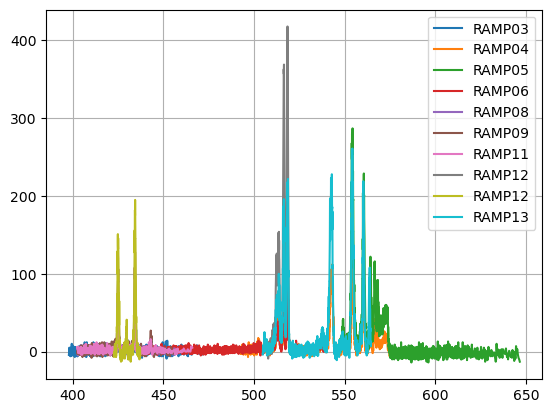

In [6]:
data_sets = [data03, data04, data05, data06, data08, data09, data11, data12, data22, data13]
# data_sets = [data04,data06]
# data_sets = [data04,data05, data13]
fig = plt.figure()
ax1 = fig.gca()
for data in data_sets:
#     ax1.plot(data.data[:,0],data.calibration_NEW2(), label = "RAMP"+data.name)
    ax1.plot(data.calibration_NEW2(), data.background_subtraction(), label = "RAMP"+data.name)
# plt.xlim(424,440)
# plt.xlim(425,425.1)
# plt.ylim(564,566)
# plt.xlim(541,544)
# plt.xlim(127,130)
plt.legend()
plt.grid()

# $\alpha = \frac{count/time { } \cdot \gamma_i^2}{n_eN_iL/C}$

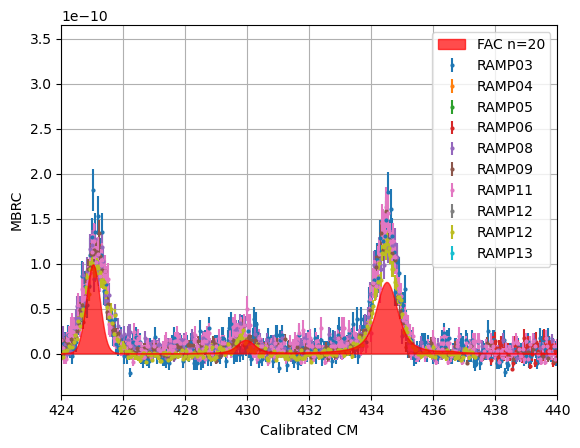

In [76]:
data_sets = [data03, data04, data05, data06, data08, data09, data11, data12, data22, data13]
# data_sets = [data06]
# data_sets = [data03, data08, data09, data11, data22]
# data_sets = [data04, data05, data06, data12, data13]
fig = plt.figure()
ax1 = fig.gca()
for data in data_sets:
    ax1.errorbar(data.calibration_NEW2(), data.rate_coef(), data.error_rate_coef(), marker='o', markersize=2, linestyle='', label = "RAMP"+data.name)
ax1.fill_between(theory_n20[:, 0], theory_n20[:, 1],color= "r", label="FAC n=20", zorder=10, alpha=0.7)
plt.xlim(424,440)
# plt.xlim(425,425.1)
# plt.xlim(540,550)
plt.legend()
plt.xlabel("Calibrated CM")
plt.ylabel("MBRC")
# plt.ylim(-0.9e-10,0.9e-10)
plt.grid()
# plt.savefig("high.pdf")

/tmp/ipykernel_3157959/203923158.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  weights = [1/d**2 for d in bin_drates]
/tmp/ipykernel_3157959/203923158.py:49: RuntimeWarning: invalid value encountered in scalar divide
  sum(r*w for r, w in zip(bin_rates, weights)) / sum(weights)


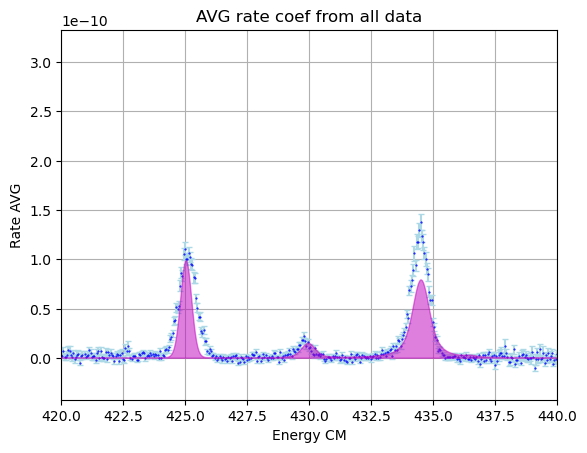

In [77]:
data_sets = [data03, data04, data05, data06, data08, data09, data11, data12, data22, data13]
# data_sets = [data08, data09, data11]

# Initialize a list to store all combined data
rate_all=[]
energy_all=[]
drate_all=[]


# Iterate over each dataset and collect the data
for dataset in data_sets:
    # Assuming each dataset has a method called `get_raw_data()` that returns the data as an array
    rate = dataset.rate_coef()
    drate = dataset.error_rate_coef()
    energy = dataset.calibration_NEW2()

    rate_all.append(rate)
    drate_all.append(drate)
    energy_all.append(energy)
    

# Flatten the lists of arrays into single 1D arrays
rate_all = np.concatenate(rate_all)
drate_all = np.concatenate(drate_all)
energies_all = np.concatenate(energy_all)

bins=np.arange(np.min(energies_all), np.max(energies_all), 0.05)

#[j][k]
rate_binned = [[] for _ in range(len(bins)-1)]
drate_binned = [[] for _ in range(len(bins)-1)]
k=0
for i in range(len(energies_all)):
    for j in range(len(bins)-1):


        if bins[j] < energies_all[i] <= bins[j + 1]:
            rate_binned[j].append(rate_all[i])
            drate_binned[j].append(drate_all[i])

rate_avg=[]
drate_avg=[]


for bin_rates, bin_drates in zip(rate_binned, drate_binned):
    if bin_rates:  # Check if the bin is not empty
        weights = [1/d**2 for d in bin_drates]
        rate_avg.append(
            sum(r*w for r, w in zip(bin_rates, weights)) / sum(weights) #ERROR dividing by zero
        )
        drate_avg.append(
            np.sqrt(1/sum(weights))
        )
    else:
        rate_avg.append(np.nan)
        drate_avg.append(np.nan)


energy_new=bins[:-1]
fig = plt.figure()
plt.errorbar(energy_new, rate_avg, drate_avg, linestyle='none', marker='.', markersize = 1, color='blue', ecolor='lightblue', capsize=2)
plt.fill_between(theory_n20[:, 0], theory_n20[:, 1],color= "m", label="FAC n=20", zorder=3, alpha=0.5)
plt.title('AVG rate coef from all data')
plt.xlabel('Energy CM')
plt.ylabel('Rate AVG')
plt.grid(True)
plt.xlim(420,440)
plt.show()
# plt.savefig("mbrc_low.pdf")

## Histograms

I am dividing by sum of N_i and n_e 

In [11]:
data04.Edensity(dataset.calibration_LAB())*1e-6

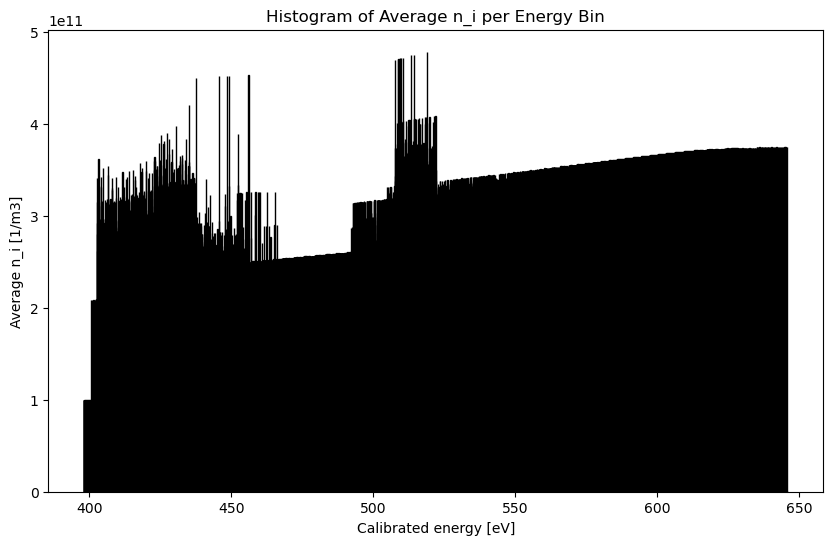

In [57]:
data_sets = [data03, data04, data05, data06, data08, data09, data11, data12, data22, data13]

# Initialize a list to store all combined data
data_all=[]
energy_all=[]
time_all=[]
N_ion_all=[]
n_e_all=[]
gamma_e_all=[]

# Iterate over each dataset and collect the data
for dataset in data_sets:
    # Assuming each dataset has a method called `get_raw_data()` that returns the data as an array
    data = dataset.background_subtraction()
    energy = dataset.calibration_NEW2()
    time = dataset.data[:,37]
    N_ion = dataset.N_ion()
    n_e = dataset.Edensity(dataset.calibration_LAB())
    gamma_e = (MASS_E + dataset.calibration_LAB()) / MASS_E
    # Append data to the combined list
    data_all.append(data)
    energy_all.append(energy)
    time_all.append(time)
    N_ion_all.append(N_ion)
    n_e_all.append(n_e)
    gamma_e_all.append(gamma_e)

# Flatten the lists of arrays into single 1D arrays
data_all = np.concatenate(data_all)
energies_all = np.concatenate(energy_all)
time_all = np.concatenate(time_all)
N_ion_all = np.concatenate(N_ion_all)
n_e_all = np.concatenate(n_e_all)
gamma_e_all = np.concatenate(gamma_e_all)


# Define your bins
bin_edges = np.arange(np.min(energies_all), np.max(energies_all), 0.05)


# Calculate histogram of sums
hist_sum, _ = np.histogram(energies_all, bins=bin_edges, weights=N_ion_all)

# Calculate histogram of counts
hist_count, _ = np.histogram(energies_all, bins=bin_edges)

# Avoid division by zero
hist_count = np.where(hist_count == 0, np.nan, hist_count)

# Calculate the average weights
hist_avg = hist_sum / hist_count

# Handle NaNs if any bins had zero entries
hist_avg = np.nan_to_num(hist_avg, nan=0.0)
# hist_avg = np.nan_to_num(hist_sum, nan=0.0)

# Create the plot
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 6))
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
ax.bar(bin_centers, hist_avg, width=np.diff(bin_edges), align='center', edgecolor='black')
ax.set_xlabel('Calibrated energy [eV]')
ax.set_ylabel('Average n_i [1/m3]')
ax.set_title('Histogram of Average n_i per Energy Bin')
# plt.xlim(425,425.1)
plt.show()

/tmp/ipykernel_2463585/2682601109.py:37: RuntimeWarning: invalid value encountered in divide
  return (count / time) * gamma**2 / (ETA * n_ion* 1e-6 * n_e * 1e-6)
/tmp/ipykernel_2463585/2682601109.py:65: RuntimeWarning: invalid value encountered in sqrt
  ax1.errorbar(bin_centers, rate_coef(hist, hist_time, 1, hist_n_ion/hist_count, hist_n_e/(hist_count)), yerr=rate_coef(np.sqrt(hist), hist_time, hist_gamma_e/hist_count, hist_n_ion/hist_count, hist_n_e/hist_count), fmt='-', color='black', ecolor='gray', label='Measured Data')


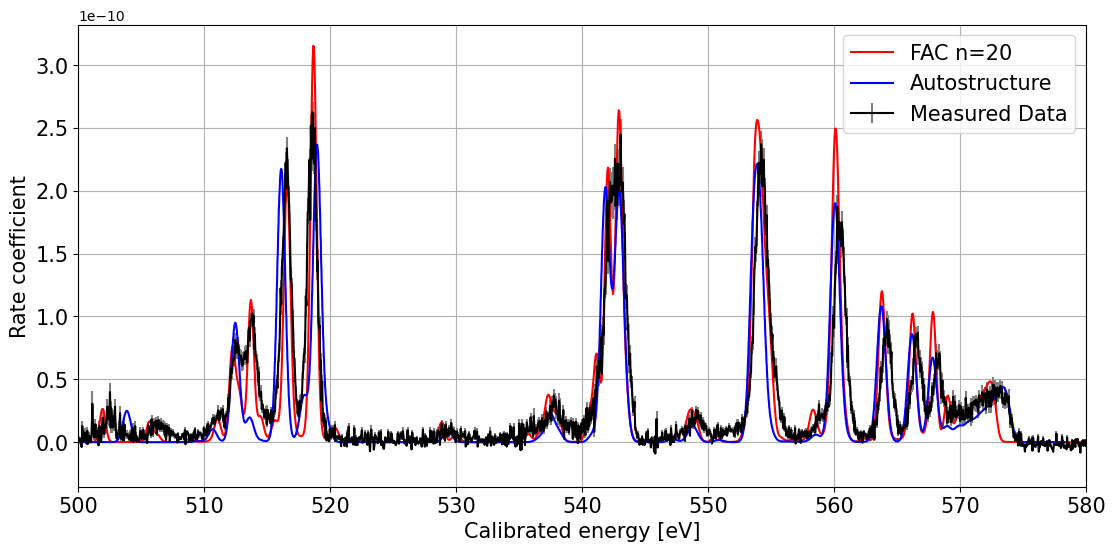

[ 2.  1.  1. ... nan nan nan]


<Figure size 640x480 with 0 Axes>

In [190]:
data_sets = [data03, data04, data05, data06, data08, data09, data11, data12, data22, data13]

# Initialize a list to store all combined data
data_all=[]
energy_all=[]
time_all=[]
N_ion_all=[]
n_e_all=[]
gamma_e_all=[]

# Iterate over each dataset and collect the data
for dataset in data_sets:
    # Assuming each dataset has a method called `get_raw_data()` that returns the data as an array
    data = dataset.background_subtraction()
    energy = dataset.calibration_NEW2()
    time = dataset.data[:,37]
    N_ion = dataset.N_ion()
    n_e = dataset.Edensity(dataset.calibration_LAB())
    gamma_e = (MASS_E + dataset.calibration_LAB()) / MASS_E
    # Append data to the combined list
    data_all.append(data)
    energy_all.append(energy)
    time_all.append(time)
    N_ion_all.append(N_ion)
    n_e_all.append(n_e)
    gamma_e_all.append(gamma_e)

# Flatten the lists of arrays into single 1D arrays
data_all = np.concatenate(data_all)
energies_all = np.concatenate(energy_all)
time_all = np.concatenate(time_all)
N_ion_all = np.concatenate(N_ion_all)
n_e_all = np.concatenate(n_e_all)
gamma_e_all = np.concatenate(gamma_e_all)

def rate_coef(count, time, gamma, n_ion, n_e):
    return (count / time) * gamma**2 / (ETA * n_ion* 1e-6 * n_e * 1e-6) 

# Define your bins
bin_edges = np.arange(np.min(energies_all), np.max(energies_all), 0.05)

# Compute histogram
hist, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=data_all)

hist_time, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=time_all )
hist_n_ion, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=N_ion_all) 
hist_n_e, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=n_e_all) 
hist_gamma_e, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=gamma_e_all) 

# Calculate histogram of counts
hist_count, _ = np.histogram(energies_all, bins=bin_edges)

# Avoid division by zero
hist_count = np.where(hist_count == 0, np.nan, hist_count)

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(13, 6))

# Calculate the bin centers from the bin edges
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2

# Plot histogram with error bars
# ax1.errorbar(bin_centers, (hist/hist_time)* hist_gamma_e**2 / (ETA * hist_n_ion * 1e-6 * hist_n_e * 1e-6) , fmt='-', color='black')
# hist_gamma_e/hist_count
ax1.errorbar(bin_centers, rate_coef(hist, hist_time, 1, hist_n_ion/hist_count, hist_n_e/(hist_count)), yerr=rate_coef(np.sqrt(hist), hist_time, hist_gamma_e/hist_count, hist_n_ion/hist_count, hist_n_e/hist_count), fmt='-', color='black', ecolor='gray', label='Measured Data')

# Additional theoretical curves
ax1.plot(theory_n20[:, 0], theory_n20[:, 1], "r-", label="FAC n=20")
ax1.plot(theory_autostructure[:, 0], theory_autostructure[:, 1], "b-", label="Autostructure")

ax1.set_xlabel('Calibrated energy [eV]', fontsize=15)
ax1.set_ylabel('Rate coefficient', fontsize=15)
plt.grid()
ax1.tick_params(axis='both', labelsize=15)
plt.legend(loc='upper right', fontsize=15)

# Display the plot
plt.xlim(410,580)
plt.xlim(420,450)
# plt.xlim(515,518)
# plt.xlim(500,535)
plt.xlim(500,580)

# plt.ylim(-0.1e-10,5e-10)

plt.show()
# plt.savefig("hist_high.pdf")
print(hist_count)

Lets now assume constant n_e N_i and gamma=1

In [14]:
data_sets = [data03, data04, data05, data06, data08, data09, data11, data12, data22, data13]

# Initialize a list to store all combined data
data_all=[]
energy_all=[]
time_all=[]
N_ion_all=[]
n_e_all=[]
gamma_e_all=[]

# Iterate over each dataset and collect the data
for dataset in data_sets:
    # Assuming each dataset has a method called `get_raw_data()` that returns the data as an array
    data = dataset.background_subtraction()
    energy = dataset.calibration_NEW2()
    time = dataset.data[:,37]
    N_ion = dataset.N_ion()
    n_e = dataset.Edensity(dataset.calibration_LAB())
    gamma_e = (MASS_E + dataset.calibration_LAB()) / MASS_E
    # Append data to the combined list
    data_all.append(data)
    energy_all.append(energy)
    time_all.append(time)
    N_ion_all.append(N_ion)
    n_e_all.append(n_e)
    gamma_e_all.append(gamma_e)

# Flatten the lists of arrays into single 1D arrays
data_all = np.concatenate(data_all)
energies_all = np.concatenate(energy_all)
time_all = np.concatenate(time_all)
N_ion_all = np.concatenate(N_ion_all)
n_e_all = np.concatenate(n_e_all)
gamma_e_all = np.concatenate(gamma_e_all)

def rate_coef(count, time, gamma, n_ion, n_e):
    return (count / time) * gamma**2 / (ETA * n_ion* 1e-6 * n_e * 1e-6) 

# Define your bins
bin_edges = np.arange(np.min(energies_all), np.max(energies_all), 0.05)

# Compute histogram
hist, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=data_all)

hist_time, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=time_all )
hist_n_ion, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=N_ion_all) #NOT!
hist_n_e, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=n_e_all) #NOT!
hist_gamma_e, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=gamma_e_all) #NOT!

# Calculate histogram of counts
hist_count, _ = np.histogram(energies_all, bins=bin_edges)

# Avoid division by zero
hist_count = np.where(hist_count == 0, np.nan, hist_count)

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(13, 6))

# Calculate the bin centers from the bin edges
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2

# Plot histogram with error bars
# ax1.errorbar(bin_centers, (hist/hist_time)* hist_gamma_e**2 / (ETA * hist_n_ion * 1e-6 * hist_n_e * 1e-6) , fmt='-', color='black')
# hist_gamma_e/hist_count
ax1.errorbar(bin_centers, rate_coef(hist, hist_time, 1, 1.4e11 ,1e13), yerr=rate_coef(np.sqrt(hist), hist_time, 1, 1.4e11 ,1e13), fmt='-', color='black', ecolor='gray', label='Measured Data')

# Additional theoretical curves
ax1.plot(theory_n20[:, 0], theory_n20[:, 1], "r-", label="FAC n=20")
ax1.plot(theory_autostructure[:, 0], theory_autostructure[:, 1], "b-", label="Autostructure")

ax1.set_xlabel('Calibrated energy [eV]', fontsize=15)
ax1.set_ylabel('Rate coefficient', fontsize=15)
plt.grid()
ax1.tick_params(axis='both', labelsize=15)
plt.legend(loc='upper right', fontsize=15)

# Display the plot
plt.xlim(410,580)
plt.xlim(420,450)
# plt.xlim(515,518)
# plt.xlim(500,535)
# plt.xlim(535,580)

# plt.ylim(-0.1e-10,5e-10)

plt.show()
print(hist_count)

To check smoothness :)

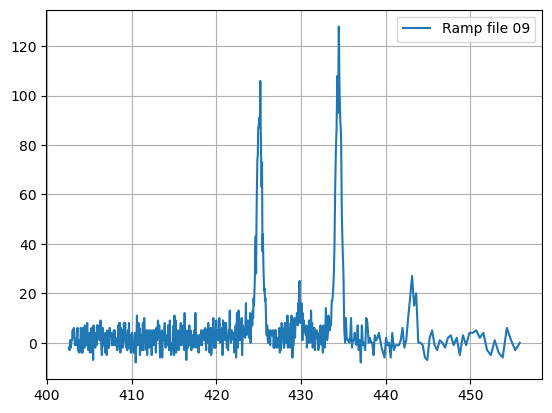

In [317]:
ax1 = plt.subplot()


# ax1.scatter(data03.calibration_NEW2(), data03.background_subtraction(), s=2, label = "Ramp file 03")
# ax1.scatter(data04.calibration_NEW2(), data04.background_subtraction(), label = "Ramp file 04")
# ax1.plot(data05.calibration_NEW2(), data05.background_subtraction(), label = "Ramp file 05")
# ax1.plot(data06.calibration_NEW2(), data06.background_subtraction(), label = "Ramp file 06")
# ax1.plot(data07.calibration_NEW2(), data07.background_subtraction(), label = "Ramp file 07")
# ax1.plot(data08.calibration_NEW2(), data08.background_subtraction(), label = "Ramp file 08")
ax1.plot(data09.calibration_NEW2(), data09.background_subtraction(), label = "Ramp file 09")
# ax1.plot(data11.calibration_NEW2(), data11.background_subtraction(), label = "Ramp file 11")
# ax1.plot(data22.calibration_NEW2(), data22.background_subtraction(), 'r-', label = "Ramp file 12")# lower energy")
# ax1.plot(data12.calibration_NEW2(), data12.background_subtraction(), 'g-', label = "Ramp file 12") #higher energy
# ax1.scatter(data13.calibration_NEW2(), data13.background_subtraction(), label = "Ramp file 13")
plt.grid()



#plt.xlim(2570,2650)
# plt.xlim(512, 513)
# plt.xlim(412,413)
# plt.ylim(-10,20)
ax1.legend(fontsize=10)